In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import IsolationForest

In [4]:
data= pd.read_csv("/kaggle/input/synthetic-log-data-of-distributed-system/logdata.csv")
print("data shape:",data.shape)
print(data.info())
data.head()

data shape: (100000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  100000 non-null  int64 
 1   Timestamp   100000 non-null  object
 2   LogLevel    100000 non-null  object
 3   Service     100000 non-null  object
 4   Message     100000 non-null  object
 5   RequestID   100000 non-null  int64 
 6   User        100000 non-null  object
 7   ClientIP    100000 non-null  object
 8   TimeTaken   100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB
None


,Unnamed: 0,Timestamp,LogLevel,Service,Message,RequestID,User,ClientIP,TimeTaken
0,0,2023-11-20T08:40:50.664842,WARNING,ServiceA,Performance Warnings,6743,User96,192.168.1.102,28ms
1,1,2023-11-20T08:40:50.672154,DEBUG,ServiceA,File I/O,8684,User17,192.168.1.219,55ms
2,2,2023-11-20T08:40:50.680263,WARNING,ServiceA,Performance Warnings,6265,User13,192.168.1.173,44ms
3,3,2023-11-20T08:40:50.688973,ERROR,ServiceA,Critical Errors,5821,User1,192.168.1.185,72ms
4,4,2023-11-20T08:40:50.697002,ERROR,ServiceB,Critical Errors,7272,User64,192.168.1.194,56ms


In [5]:
data =  data.drop("Unnamed: 0", axis=1) # dropping the index column
data["Timestamp"]= pd.to_datetime(data["Timestamp"])  #convert timestamp to datetime type
data.rename(columns={"TimeTaken": "TimeTaken_ms"}, inplace=True) #renaming the time column 
data["TimeTaken_ms"] = data["TimeTaken_ms"].str.replace("ms", "", regex=False).astype(int) # stripping the ms

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Timestamp     100000 non-null  datetime64[ns]
 1   LogLevel      100000 non-null  object        
 2   Service       100000 non-null  object        
 3   Message       100000 non-null  object        
 4   RequestID     100000 non-null  int64         
 5   User          100000 non-null  object        
 6   ClientIP      100000 non-null  object        
 7   TimeTaken_ms  100000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 6.1+ MB
None


,Timestamp,LogLevel,Service,Message,RequestID,User,ClientIP,TimeTaken_ms
0,2023-11-20 08:40:50.664842,WARNING,ServiceA,Performance Warnings,6743,User96,192.168.1.102,28
1,2023-11-20 08:40:50.672154,DEBUG,ServiceA,File I/O,8684,User17,192.168.1.219,55
2,2023-11-20 08:40:50.680263,WARNING,ServiceA,Performance Warnings,6265,User13,192.168.1.173,44
3,2023-11-20 08:40:50.688973,ERROR,ServiceA,Critical Errors,5821,User1,192.168.1.185,72
4,2023-11-20 08:40:50.697002,ERROR,ServiceB,Critical Errors,7272,User64,192.168.1.194,56


In [67]:
# checking for missing values in each column
data.isna().sum()

Timestamp       0
LogLevel        0
Service         0
Message         0
RequestID       0
User            0
ClientIP        0
TimeTaken_ms    0
dtype: int64

In [6]:
data = data.set_index("Timestamp") # Setting timestamp as index
data.head()

,LogLevel,Service,Message,RequestID,User,ClientIP,TimeTaken_ms
Timestamp,,,,,,,
2023-11-20 08:40:50.664842,WARNING,ServiceA,Performance Warnings,6743,User96,192.168.1.102,28
2023-11-20 08:40:50.672154,DEBUG,ServiceA,File I/O,8684,User17,192.168.1.219,55
2023-11-20 08:40:50.680263,WARNING,ServiceA,Performance Warnings,6265,User13,192.168.1.173,44
2023-11-20 08:40:50.688973,ERROR,ServiceA,Critical Errors,5821,User1,192.168.1.185,72
2023-11-20 08:40:50.697002,ERROR,ServiceB,Critical Errors,7272,User64,192.168.1.194,56


In [69]:
# Checking for any duplicate entries
data.duplicated().any()

False

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2023-11-20 08:40:50.664842 to 2023-11-20 09:04:19.624710
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   LogLevel      100000 non-null  object
 1   Service       100000 non-null  object
 2   Message       100000 non-null  object
 3   RequestID     100000 non-null  int64 
 4   User          100000 non-null  object
 5   ClientIP      100000 non-null  object
 6   TimeTaken_ms  100000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 6.1+ MB


### Exploratory Data Analysis (EDA)

### Distribution of LogLevel and How much each service contributes to the logs
WARNING is the most frequent log level, indicating the System is encountering many non-critical issues. Even though, they signals conditions that require attention to prevent escalation.

Each service contributes roughly the same volume of logs (~25k each), showing that logging load is balanced across the infrastructure.

Service C has a slight lead over the others, indicating it’s either handling a bit more workload or logging more aggressively.


In [74]:
categorical_cols = ["LogLevel", "Service"]

for col in categorical_cols:
    print(f"\n--- {col} ---")
    print("Unique values:", data[col].nunique())
    perc = data[col].value_counts()
    print(perc)


--- LogLevel ---
Unique values: 5
LogLevel
WARNING    26181
DEBUG      25901
INFO       20142
ERROR      15851
FATAL      11925
Name: count, dtype: int64

--- Service ---
Unique values: 4
Service
ServiceC    25200
ServiceD    25139
ServiceA    24886
ServiceB    24775
Name: count, dtype: int64


### Log Activity Over Time with Rolling Average
Below, the system was active and busier the entire period with bursts, suggesting workload fluctuation.

The log activity generally is between 65 and 75 logs per second, with bursts reaching the 80–90 range, indicating short-term workload fluctuations.

There is no clear upward or downward drift during the observed window, suggesting steady workload.

Overall, the system seems relatively stable the with normal fluctuations and a few anomalies worth monitoring.



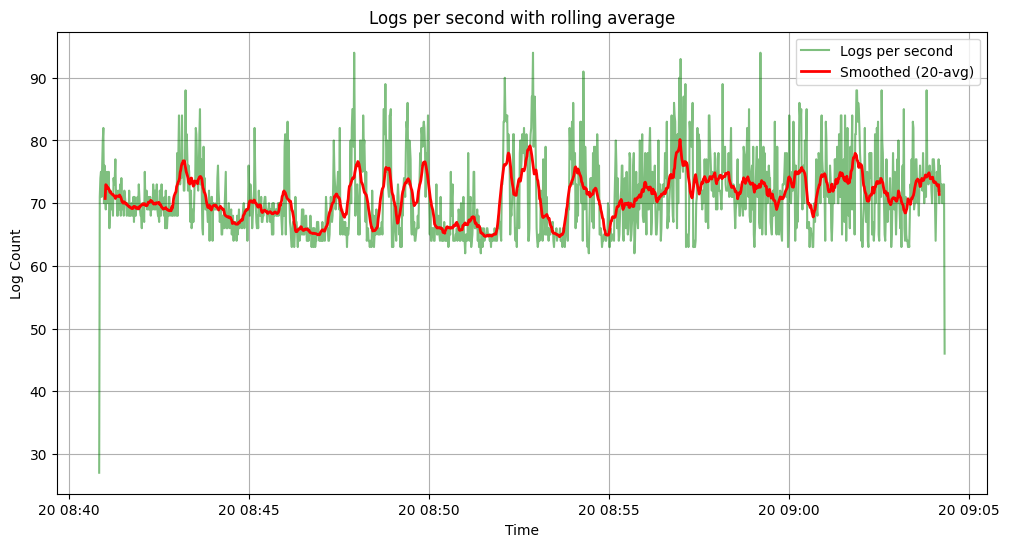

In [117]:
# Resample per second for all logs
logs_per_sec = data.resample("s").size()

# smoothing the spikes based on last 20 seconds.
smoothed = logs_per_sec.rolling(window=20, center=True).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(logs_per_sec.index, logs_per_sec.values, color="green", alpha=0.5, label="Logs per second")
plt.plot(smoothed.index, smoothed.values, color="red", linewidth=2, label="Smoothed (20-avg)")

plt.title("Logs per second with rolling average")
plt.xlabel("Time")
plt.ylabel("Log Count")
plt.legend()
plt.grid(True)
plt.show()

### How Services log overtime: Which service is behaving unusually?

All services are logging in the 500–600 logs range with similar fluctuations, indicating shared system behavior such as traffic load increasing across all services at once, overtime.

If one service dropped out while others stayed steady, that would suggest a problem in that specific service, but here, all four seem healthy.

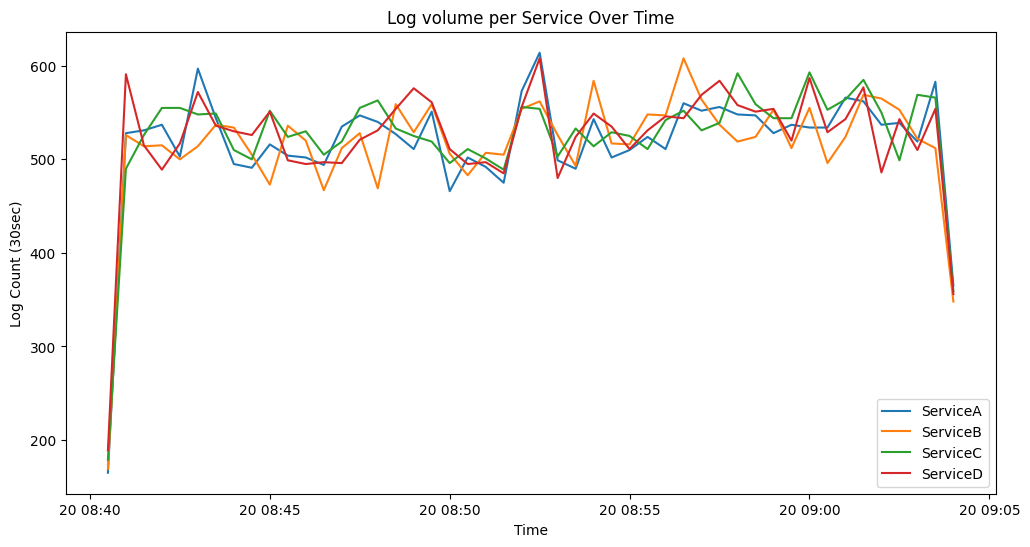

In [13]:
# Count logs per service per minute
logs_per_service = (
    data.groupby('Service')
      .resample("30s")
      .size()
      .unstack(level=0)   
      .fillna(0)
)

plt.figure(figsize=(12,6))
for service in logs_per_service.columns:
    plt.plot(logs_per_service.index, logs_per_service[service], label=service)

plt.title("Log volume per Service Over Time")
plt.xlabel("Time")
plt.ylabel("Log Count (30sec)")
plt.legend()
plt.show()

### Error and Fatal concentration per service: Plotting the percentage distribution of ERROR and FATAL Logs Across Services
Each service contributes an almost similar ratio of ERROR vs FATAL logs,suggesting that the failures are not isolated to a single service but are are system-wide.



Even though, the consistent high volume of such logs show reliability problems in the system and critical failure risks and areas that require immediate investigation.


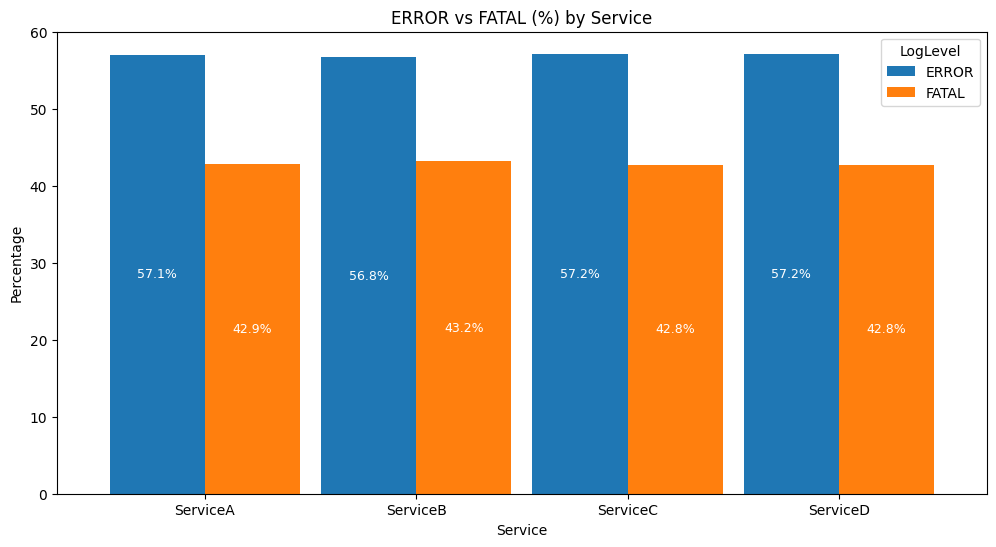

In [13]:
# filter only ERROR and FATAL
filtered = data[data["LogLevel"].isin(["ERROR", "FATAL"])]

# compute percentages per service
counts = filtered.groupby(["Service","LogLevel"]).size().reset_index(name="count")
counts["percent"] = counts.groupby("Service")["count"].transform(lambda x: 100 * x / x.sum())

# pivot for plotting
pivot = counts.pivot(index="Service", columns="LogLevel", values="percent")

# plot
ax = pivot.plot(kind="bar",width=0.9,  figsize=(12,6),stacked=False)
plt.ylabel("Percentage")
plt.title("ERROR vs FATAL (%) by Service")

# add percentage labels inside bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height/2),  # place inside bar
                    ha='center', va='center', color='white', fontsize=9)


plt.xticks(rotation=0, ha="center")
plt.show()

### Average latency by service: : How fast or slow services respond under load.
All bars are about the same height, with an average latency above 55 ms, suggesting that the average latency across all four services is balanced, but not fast.

Overall, requests take noticeably long across the board, reflecting a system-wide performance issue.

Latency being consistently above 55 ms indicates that the system is already under noticeable load and if workload increases further, latency will likely rise even more(system is approaching its capacity limit).Therefore, scaling resources or optimizing shared components is needed to keep performance stable.

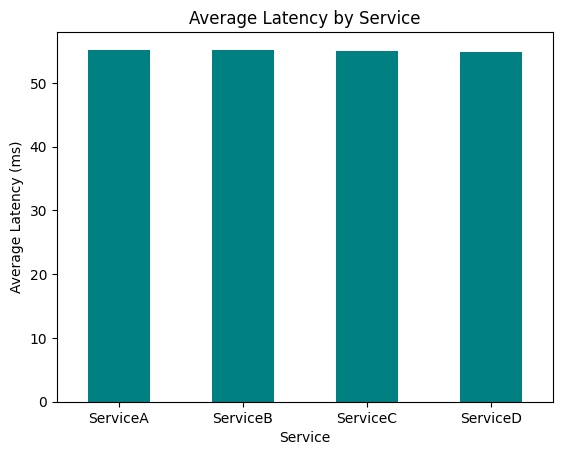

In [12]:
# Use TimeTaken averages grouped by service
avg_latency = data.groupby("Service")["TimeTaken_ms"].mean().sort_values(ascending=False)

# Plot
avg_latency.plot(kind="bar", color="teal")
plt.ylabel("Average Latency (ms)")
plt.title("Average Latency by Service")
plt.xticks(rotation=0, ha="center")
plt.show()

### Latency trend overtime

Below, latency over time is unstable, with sharp rises and sudden drops including two large dips,indicating moments when requests take significantly longer, sometimes shorter.

The System may be struggling due to workload surges or temporary service interruptions.

Overall, the system performance is unstable and not holding a steady response time.

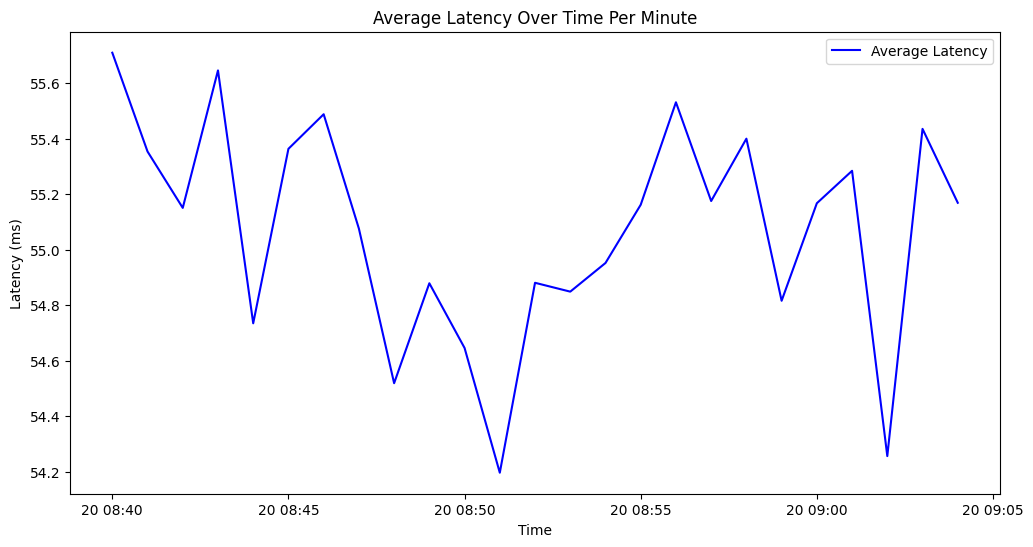

In [132]:
# Resample per second
latency_trend = data["TimeTaken_ms"].resample("1min").mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(latency_trend.index, latency_trend, color="blue", label="Average Latency")

plt.title("Average Latency Over Time Per Minute")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

### All Messages frequency
Majority of logs are routine status updates and startup events, representing normal system operations, but a significant portion consists of warnings and errors. 

Additionally, frequent Resource and Performance warnings suggest the system often operates under resource strain or is approaching performance limits.

In [133]:
# All log messages 
top_msgs = data["Message"].value_counts()
print(top_msgs)

Message
Status Updates               10094
Startup Messages             10048
Resource Warnings             8785
Performance Warnings          8774
Input Validation Warnings     8622
Database Errors               8009
Critical Errors               7842
File I/O                      6613
Trace Information             6542
Algorithm Steps               6479
SQL Queries                   6267
Crashes                       5968
Data Corruption               5957
Name: count, dtype: int64


### Log Messages for all ERROR and FATAL
Below, Database Errors and Critical Errors dominate, both near 8,000 logs, very likely the root causes of instability.

Data Corruption and Crashes are also major, but slightly less frequent (6,000).



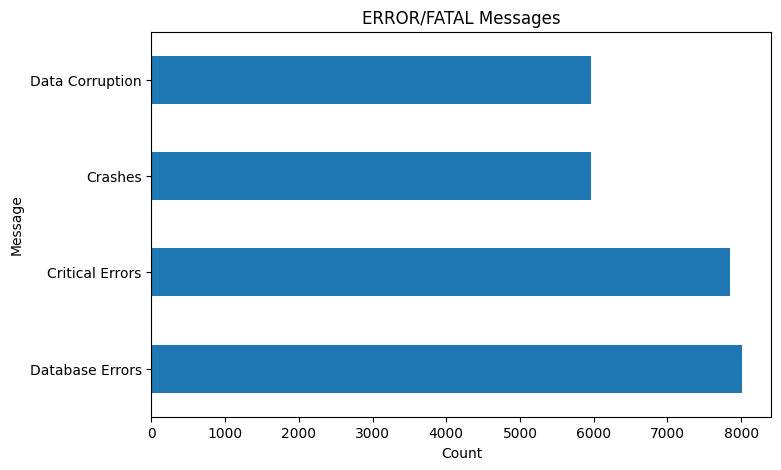

In [134]:
# ERROR and FATAL
top_err_fatal = data[data["LogLevel"].isin(["ERROR","FATAL"])]["Message"].value_counts()

# Plot
top_err_fatal.plot(kind="barh", figsize=(8,5))
plt.xlabel("Count")
plt.ylabel("Message")
plt.title("ERROR/FATAL Messages")
plt.show()

### Isolation Forest anomaly detection

In [151]:

# Aggregate per second instead of per minute
df_trend = data.resample("5s").agg({
    "TimeTaken_ms": "mean",
    "LogLevel": lambda x: (x.isin(["ERROR","FATAL"])).sum()
}).fillna(0)

# Fit Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
df_trend["anomaly"] = model.fit_predict(df_trend)

# Extract anomalies
anomalies = df_trend[df_trend["anomaly"] == -1]

### Latency Over Time with Anomalies
From the graph, most latency values stay within a fairly stable range (around 52–58 ms), with a few sharp drops and spikes where the latency deviated significantly from the usual expected pattern. 

These anomalies may indicate situations like network issues or workload spikes that are worth investigating.

The Infrastructure team can identify performance issues early, so they can be mitigated and improve the system resilience.

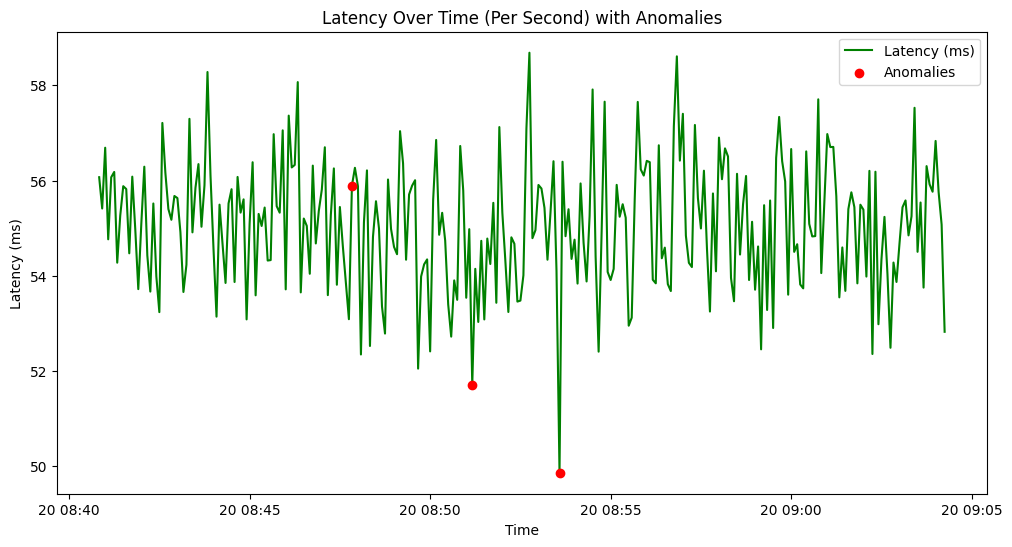

In [152]:
plt.figure(figsize=(12,6))
plt.plot(df_trend.index, df_trend["TimeTaken_ms"], color="green", label="Latency (ms)")
plt.scatter(anomalies.index, anomalies["TimeTaken_ms"], color="red", label="Anomalies", zorder=5)

plt.title("Latency Over Time (Per Second) with Anomalies")
plt.xlabel("Time")
plt.ylabel("Latency trend (ms)")
plt.legend()
plt.show()

### Error/Fatal Logs Over Time with Anomalies
This chart tracks the count of error and fatal logs per second across the system, with anomalies detected automatically.
There are large deviations, example, the spike around 130 errors/sec which may signal critical incidents such as service degradation that require immediate investigation.

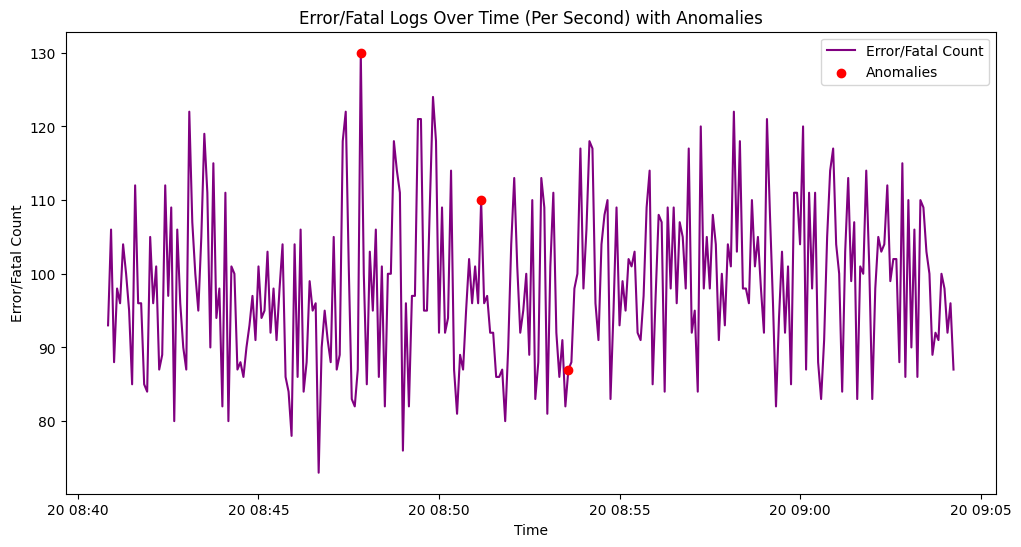

In [153]:
plt.figure(figsize=(12,6))
plt.plot(df_trend.index, df_trend["LogLevel"], color="purple", label="Error/Fatal Count")
plt.scatter(anomalies.index, anomalies["LogLevel"], color="red", label="Anomalies", zorder=5)

plt.title("Error/Fatal Logs Over Time (Per Second) with Anomalies")
plt.xlabel("Time")
plt.ylabel("Error/Fatal Count")
plt.legend()
plt.show()